In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import numpy as np
from tqdm import tqdm
import imageio
import os
import torch
import torchvision.transforms.functional as tvf
from utils import visualization, dataloader, utils
from skimage.metrics import structural_similarity as ssim

In [2]:
def draw_xywha(im, x, y, w, h, angle, color, linewidth=5):
    '''
    im: image numpy array, shape(h,w,3), RGB
    angle: degree
    '''
    c, s = np.cos(angle/180*np.pi), np.sin(angle/180*np.pi)
    R = np.asarray([[c, s], [-s, c]])
    pts = np.asarray([[-w/2, -h/2], [w/2, -h/2], [w/2, h/2], [-w/2, h/2]])
    rot_pts = []
    for pt in pts:
        rot_pts.append(([x, y] + pt @ R).astype(int))
    contours = np.array([rot_pts[0], rot_pts[1], rot_pts[2], rot_pts[3]])
    cv2.polylines(im, [contours], isClosed=True, color=color,
                thickness=linewidth, lineType=cv2.LINE_4)

In [3]:
def draw_dt_on_np(im, detections, print_dt=False,
                  text_size=1, **kwargs):
    '''
    im: image numpy array, shape(h,w,3), RGB
    detections: rows of [x,y,w,h,a,conf], angle in degree
    '''
    color_palette = [
        (178, 75, 163),
        (71, 91, 61),
        (156, 248, 63),
        (4, 120, 145),
        (62, 194, 253),
        (150, 20, 54),
        (215, 100, 218),
        (51, 6, 117),
        (210, 108, 19),
        (97, 164, 188),
        (197, 1, 135),
        (141, 197, 114),
        (55, 45, 73),
        (35, 160, 120),
        (210, 60, 242),
        (173, 113, 139),
        (152, 230, 22),
        (28, 94, 162),
        (41, 98, 59),
        (213, 86, 238)
    ]
    line_width = kwargs.get('line_width', im.shape[0] // 300)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_bold = max(int(2*text_size), 1)
    for idx, bb in enumerate(detections):
        if len(bb) == 6:
            x,y,w,h,a,conf = bb
        else:
            x,y,w,h,a = bb[:5]
            conf = -1
        x1, y1 = x - w/2, y - h/2
        if print_dt:
            print(f'[{x} {y} {w} {h} {a}], confidence: {conf}')
        draw_xywha(im, x, y, w, h, a, color=color_palette[idx], linewidth=line_width)
        if kwargs.get('show_conf', True):
            cv2.putText(im, f'{conf:.2f}', (int(x1),int(y1)), font, 1*text_size,
                        (255,255,255), font_bold, cv2.LINE_AA)
        if kwargs.get('show_angle', False):
            cv2.putText(im, f'{int(a)}', (x,y), font, 1*text_size,
                        (255,255,255), font_bold, cv2.LINE_AA)
    if kwargs.get('show_count', True):
        caption_w = int(im.shape[0] / 4.8)
        caption_h = im.shape[0] // 25
        start = (im.shape[1] - caption_w, im.shape[0] // 20)
        end = (im.shape[1], start[1] + caption_h)
        # cv2.rectangle(im, start, end, color=(0,0,0), thickness=-1)
        cv2.putText(im, f'Count: {len(detections)}',
                    (im.shape[1] - caption_w + im.shape[0]//100, end[1]-im.shape[1]//200),
                    font, 1.2*text_size,
                    (255,255,255), font_bold*2, cv2.LINE_AA)

In [4]:
def extract_rotated_roi(img, x, y, w, h, angle):
    try:
        center = (int(x + w/2), int(y + h/2))
        size = (int(w), int(h))

        # Check if the size is valid
        if w <= 0 or h <= 0:
            return None

        # Get rotation matrix
        angle = float(angle)
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Adjust dimensions to accommodate rotation
        cos = np.abs(rot_mat[0, 0])
        sin = np.abs(rot_mat[0, 1])
        new_w = int((h * sin) + (w * cos))
        new_h = int((h * cos) + (w * sin))

        # Adjust matrix for translation to center rotated image
        rot_mat[0, 2] += (new_w / 2) - center[0]
        rot_mat[1, 2] += (new_h / 2) - center[1]

        # Rotate and extract the ROI
        rotated_img = cv2.warpAffine(img, rot_mat, (new_w, new_h), flags=cv2.INTER_LINEAR)
        return rotated_img
    except Exception as e:
        print(f"Error in extract_rotated_roi: {e}")
        return None

In [5]:
def compare_images(imageA, imageB):
    # Convert PIL Images to NumPy arrays
    imageA = np.array(imageA)
    imageB = np.array(imageB)
    
    # Determine the size of both images
    heightA, widthA = imageA.shape[:2]
    heightB, widthB = imageB.shape[:2]

    # Determine the new dimensions based on the smaller image
    new_height = min(heightA, heightB)
    new_width = min(widthA, widthB)
    
    # Resize both images to the dimension of the smaller one
    imageA = cv2.resize(imageA, (new_width, new_height), interpolation=cv2.INTER_AREA)
    imageB = cv2.resize(imageB, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Ensure both images are the same size before computing SSIM
    # Determine the appropriate window size
    min_dimension = min(imageA.shape[:2])
    win_size = min(7, min_dimension)  # ssim default win_size is 7
    if win_size % 2 == 0:
        win_size -= 1  # Ensure win_size is odd

    # Set the channel_axis for multichannel (color) images
    if imageA.ndim == 3 and imageA.shape[2] == 3:
        channel_axis = 2
    else:
        channel_axis = None  # Use None for grayscale images

    # Compute the SSIM between the two images, assuming they are in grayscale or multichannel
    s = ssim(imageA, imageB, multichannel=True, win_size=win_size, channel_axis=channel_axis)
    return s

In [6]:
def extract_person_image(im, detections):
    extracted_persons = []
    for bb in detections:
        if bb == (0,0,0,0,0) or len(bb) < 6:
            continue
        x, y, w, h, a, conf = bb[:6]
        if w <= 0 or h <= 0:  # Ensure valid dimensions
            continue
        extracted_img = extract_rotated_roi(im, x, y, w, h, a)
        if extracted_img is not None:
            extracted_persons.append(extracted_img)
    return extracted_persons

In [7]:
def sort_people(detection_persons, detection):
    similarity = None
    if all(x is None for x in person_matrix):
        for i in range(len(detection_persons)):
            person_matrix[i] = detection_persons[i]
            box_matrix[i] = detection[i]
    else:
        # for person in detection_persons:
        #     similarity = [compare_images(person, person_matrix[i]) for i in range(len(person_matrix))]
        # print(f"person_matrix: {type(person_matrix)}")
        for arf in range(len(person_matrix)):
            if person_matrix[arf] is None:
                # print(f"person_matrix[arf]: is None,\n similarity: {similarity}")
                continue
            else:
                # for person in range(len(detection_persons)):
                similarity = [compare_images(detection_persons[i], person_matrix[arf]) for i in range(len(detection_persons))]
                a = person_matrix[arf]
                z = np.argmax(similarity) 
                b = detection_persons[np.argmax(similarity)]
                person_matrix[arf] = detection_persons[np.argmax(similarity)]
                box_matrix[arf] = detection[np.argmax(similarity)]
                # detection_persons[np.argmax(similarity)] =
                # del detection_persons[person] 
                # print(similarity)

In [9]:
class Detector():
    '''
    Wrapper of image object detectors.

    Args:
        model_name: str, currently only support 'rapid'
        weights_path: str, path to the pre-trained network weights
        model: torch.nn.Module, used only during training
        conf_thres: float, confidence threshold
        input_size: int, input resolution
    '''
    def __init__(self, model_name='', weights_path=None, model=None, **kwargs):
        # post-processing settings
        self.conf_thres = kwargs.get('conf_thres', None)
        self.input_size = kwargs.get('input_size', None)

        if model:
            self.model = model
            return
        if model_name == 'rapid':
            from models.rapid import RAPiD
            model = RAPiD(backbone='dark53')
        elif model_name == 'rapid_export': # testing-only version
            from models.rapid_export import RAPiD
            model = RAPiD()
        else:
            raise NotImplementedError()
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Successfully initialized model {model_name}.',
            'Total number of trainable parameters:', total_params)

        model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])
        print(f'Successfully loaded weights: {weights_path}')
        model.eval()
        if kwargs.get('use_cuda', True):
            print("Using CUDA...")
            assert torch.cuda.is_available()
            self.model = model.cuda()
        else:
            print("Using CPU instead of CUDA...")
            self.model = model

    def get_image_resolution(self, image_path):
        img = imageio.imread(image_path)
        height, width = img.shape[:2]
        return width, height
            
    def detect_one(self, **kwargs):
        '''
        Inference on a single image.

        Args:
            img_path: str or pil_img: PIL.Image

            input_size: int, input resolution
            conf_thres: float, confidence threshold

            return_img: bool, if True, return am image with bbox visualizattion. \
                default: False
            visualize: bool, if True, plt.show the image with bbox visualization. \
                default: False
        '''
        assert 'img_path' in kwargs or 'pil_img' in kwargs
        img = kwargs.pop('pil_img', None) or Image.open(kwargs['img_path'])

        detections = self._predict_pil(img, **kwargs)

        if kwargs.get('return_img', False):
            np_img = np.array(img)
            visualization.draw_dt_on_np(np_img, detections, **kwargs)
            return np_img
        if kwargs.get('visualize', False):
            np_img = np.array(img)
            visualization.draw_dt_on_np(np_img, detections, **kwargs)
            plt.figure(figsize=(10,10))
            plt.imshow(np_img)
            plt.show()
        return detections

    def detect_imgSeq(self, img_dir, **kwargs):
        '''
        Run on a sequence of images in a folder.

        Args:
            img_dir: str
            input_size: int, input resolution
            conf_thres: float, confidence threshold
        '''
        gt_path = kwargs['gt_path'] if 'gt_path' in kwargs else None

        ims = dataloader.Images4Detector(img_dir, gt_path) # TODO
        dts = self._detect_iter(iter(ims), **kwargs)
        return dts

    def _detect_iter(self, iterator, **kwargs):
        detection_json = []
        for _ in tqdm(range(len(iterator))):
            pil_frame, anns, img_id = next(iterator)
            detections = self._predict_pil(pil_img=pil_frame, **kwargs)

            detection_persons = extract_person_image(np.array(pil_frame), detections)
            sort_people(detection_persons, detections)
            
            np_img = np.array(pil_frame)
            draw_dt_on_np(np_img, box_matrix, return_img=True, input_size=1024, conf_thres=0.5, test_aug=None)
            plt.figure(figsize=(10,10))
            plt.imshow(np_img)
            plt.show()

        #     for dt in detections:
        #         x, y, w, h, a, conf = [float(t) for t in dt]
        #         bbox = [x,y,w,h,a]
        #         dt_dict = {'image_id': img_id, 'bbox': bbox, 'score': conf,
        #                    'segmentation': []}
        #         detection_json.append(dt_dict)

        # return detection_json

    def _predict_pil(self, pil_img, **kwargs):
        '''
        Args:
            pil_img: PIL.Image.Image
            input_size: int, input resolution
            conf_thres: float, confidence threshold
        '''
        input_size = kwargs.get('input_size', self.input_size)
        conf_thres = kwargs.get('conf_thres', self.conf_thres)
        assert isinstance(pil_img, Image.Image), 'input must be a PIL.Image'
        assert input_size is not None, 'Please specify the input resolution'
        assert conf_thres is not None, 'Please specify the confidence threshold'

        # pad to square
        input_img, _, pad_info = utils.rect_to_square(pil_img, None, input_size, 0)

        input_ori = tvf.to_tensor(input_img)
        input_ = input_ori.unsqueeze(0)

        assert input_.dim() == 4
        device = next(self.model.parameters()).device
        input_ = input_.to(device=device)
        with torch.no_grad():
            dts = self.model(input_).cpu()

        dts = dts.squeeze()
        # post-processing
        dts = dts[dts[:,5] >= conf_thres]
        if len(dts) > 1000:
            _, idx = torch.topk(dts[:,5], k=1000)
            dts = dts[idx, :]
        if kwargs.get('debug', False):
            np_img = np.array(input_img)
            visualization.draw_dt_on_np(np_img, dts)
            plt.imshow(np_img)
            plt.show()
        dts = utils.nms(dts, is_degree=True, nms_thres=0.45, img_size=input_size)
        dts = utils.detection2original(dts, pad_info.squeeze())
        if kwargs.get('debug', False):
            np_img = np.array(pil_img)
            visualization.draw_dt_on_np(np_img, dts)
            plt.imshow(np_img)
            plt.show()
        return dts


def detect_once(model, pil_img, conf_thres, nms_thres=0.45, input_size=608):
    '''
    Run the model on the pil_img and return the detections.
    '''
    device = next(model.parameters()).device
    ori_w, ori_h = pil_img.width, pil_img.height
    input_img, _, pad_info = utils.rect_to_square(pil_img, None, input_size, 0)

    input_img = tvf.to_tensor(input_img).to(device=device)
    with torch.no_grad():
        dts = model(input_img[None]).cpu().squeeze()
    dts = dts[dts[:,5] >= conf_thres].cpu()
    dts = utils.nms(dts, is_degree=True, nms_thres=0.45)
    dts = utils.detection2original(dts, pad_info.squeeze())
    # np_img = np.array(pil_img)
    # api_utils.draw_dt_on_np(np_img, detections)
    # plt.imshow(np_img)
    # plt.show()
    return dts


In [10]:
# weights can be downloaded from
# https://github.com/duanzhiihao/RAPiD/releases/download/v0.1/pL1_MWHB608_Mar11_4500.ckpt
detector = Detector(model_name='rapid',
                    weights_path='./weights/pL1_MWHB1024_Mar11_4000.ckpt',
                    use_cuda=True)

Using backbone Darknet-53. Loading ImageNet weights....
Number of parameters in backbone: 40584928
Successfully initialized model rapid. Total number of trainable parameters: 61523734
Successfully loaded weights: ./weights/pL1_MWHB1024_Mar11_4000.ckpt
Using CUDA...


Iteration 0


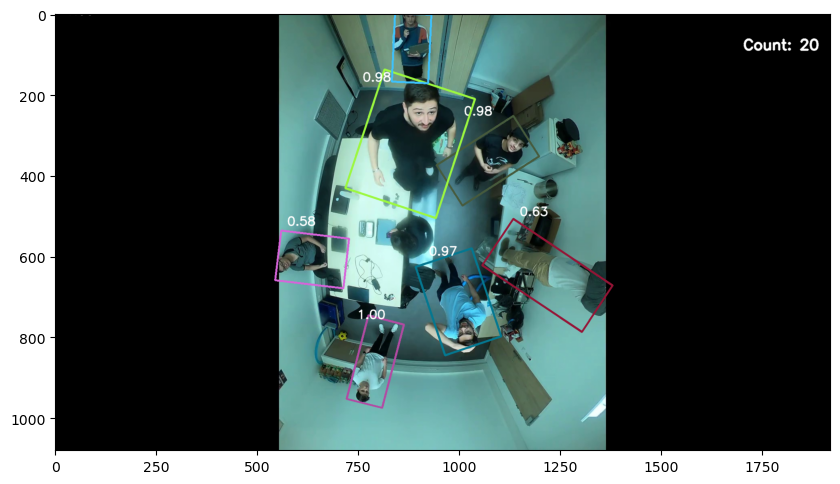

Iteration 1


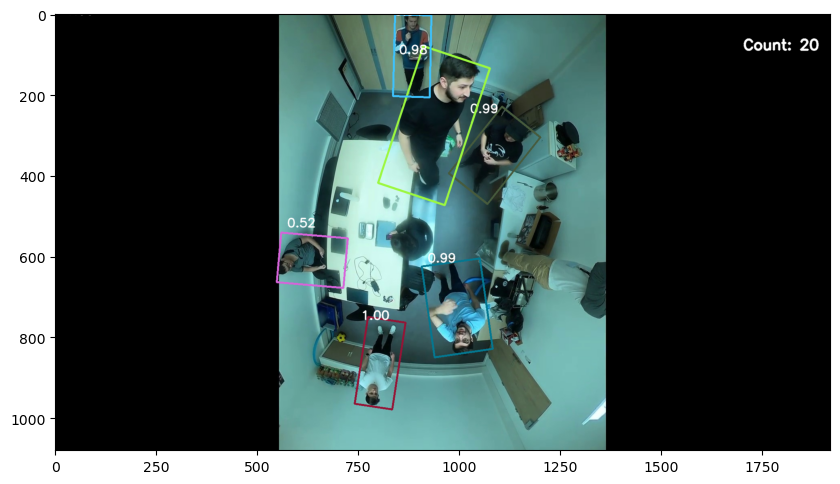

Iteration 2


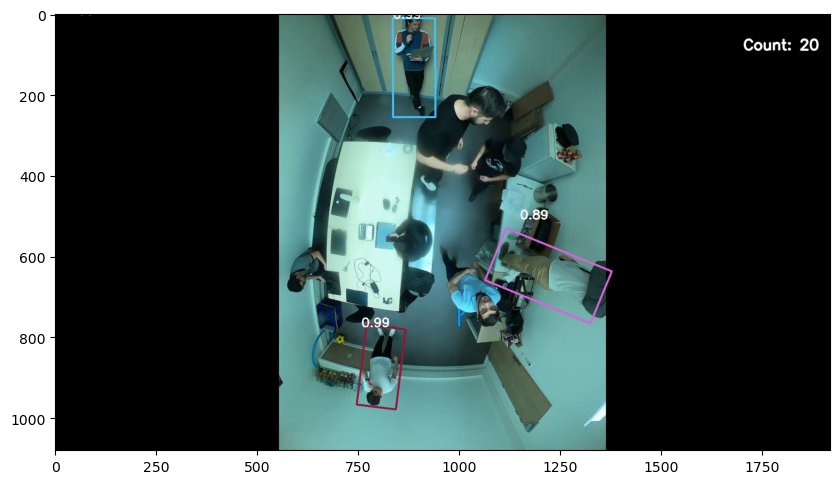

Iteration 3


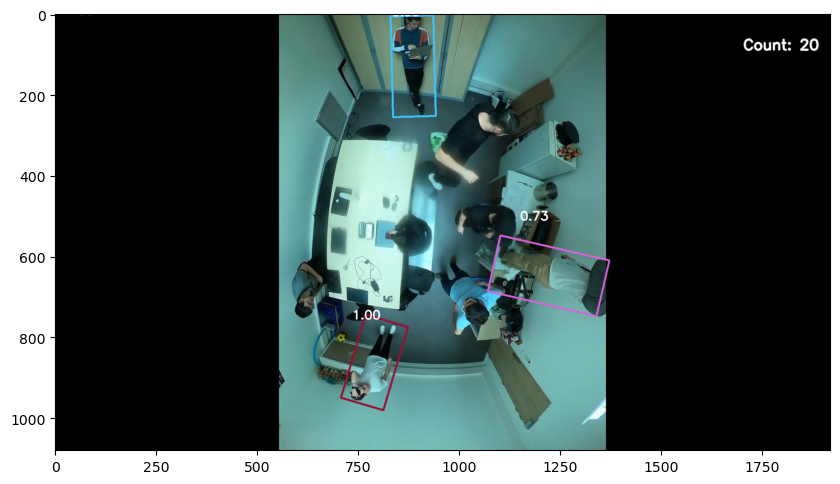

Iteration 4


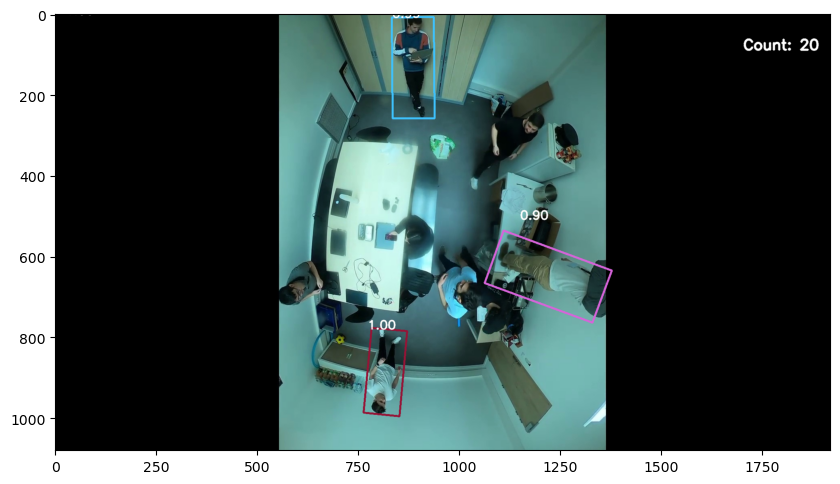

Iteration 5


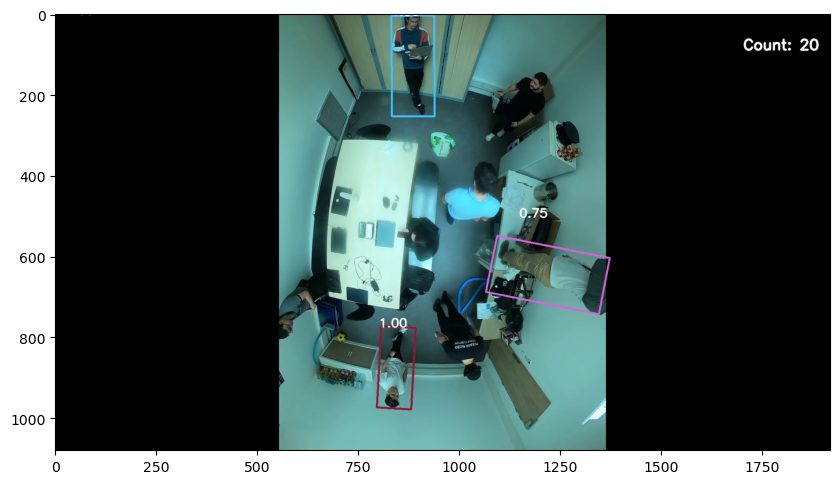

Iteration 6


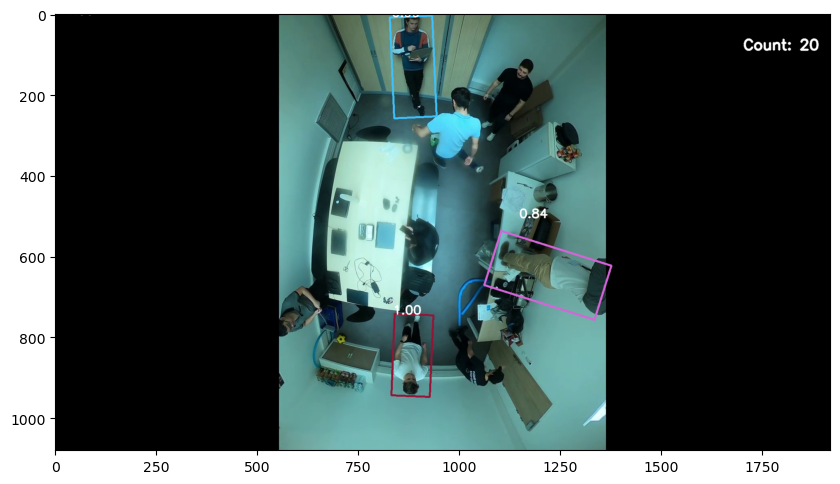

Iteration 7


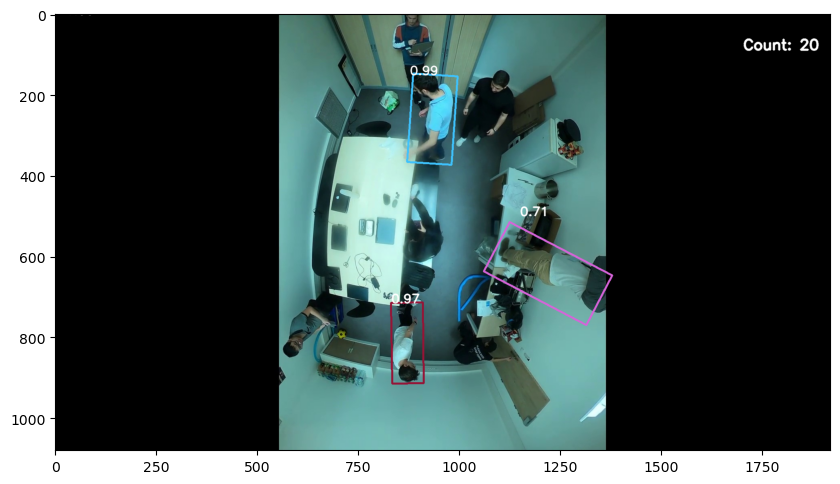

Iteration 8


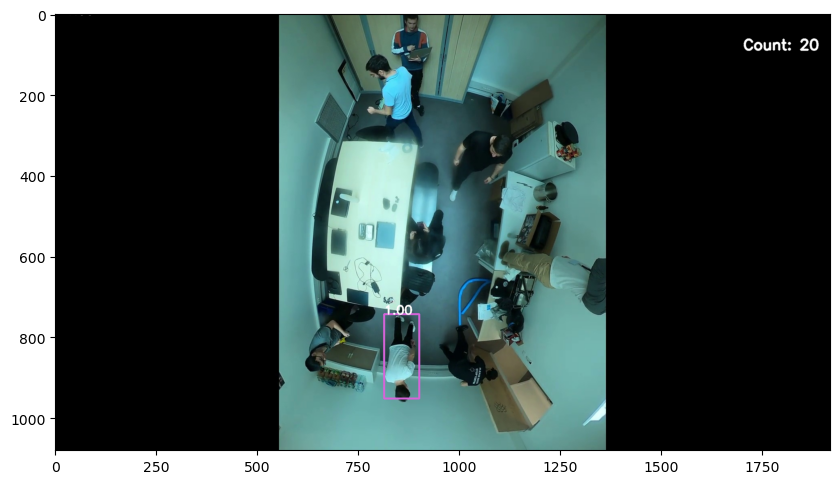

Iteration 9


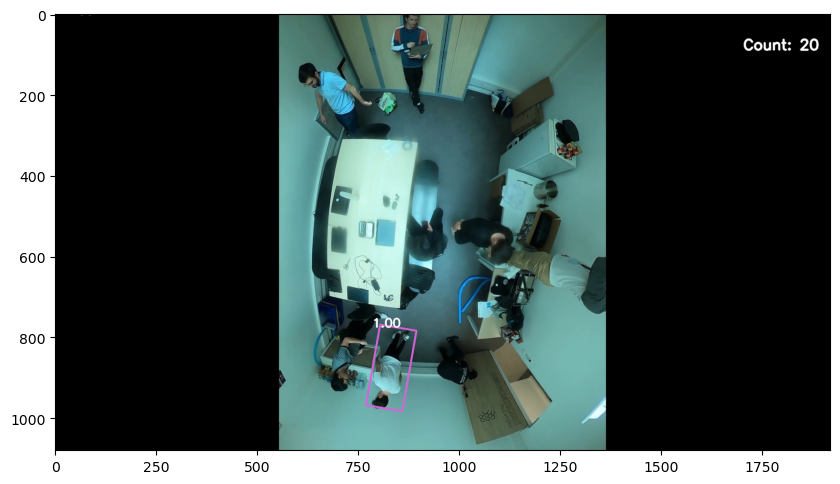

Iteration 10


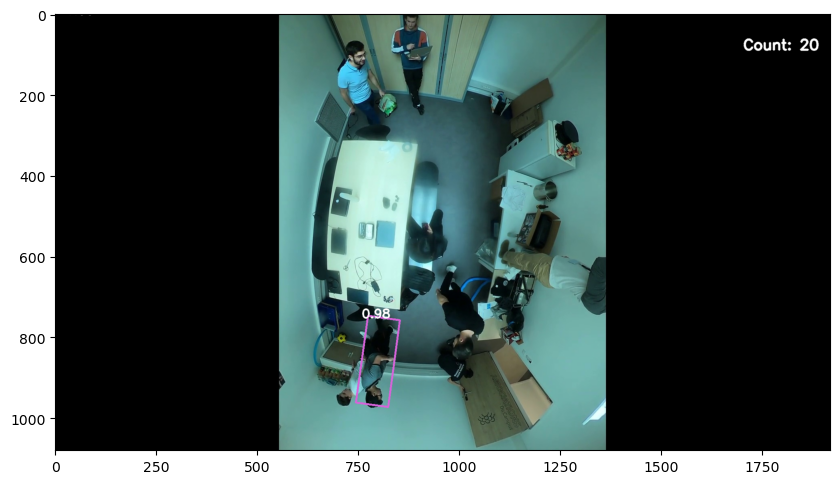

Iteration 11


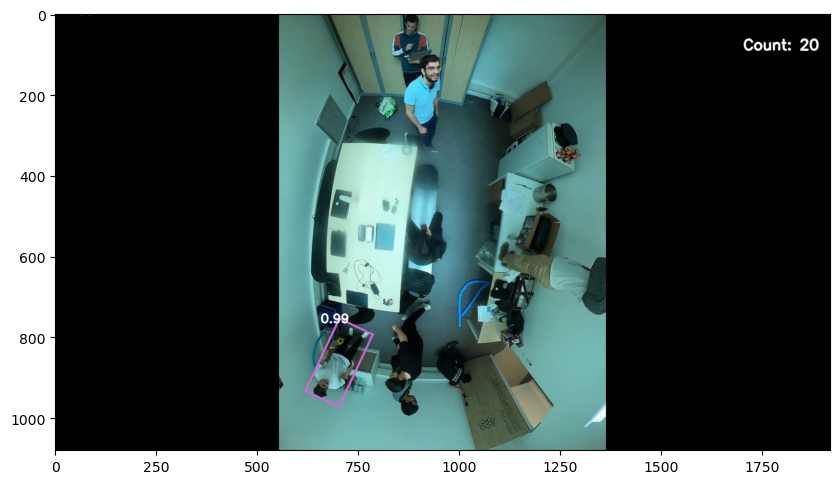

Iteration 12


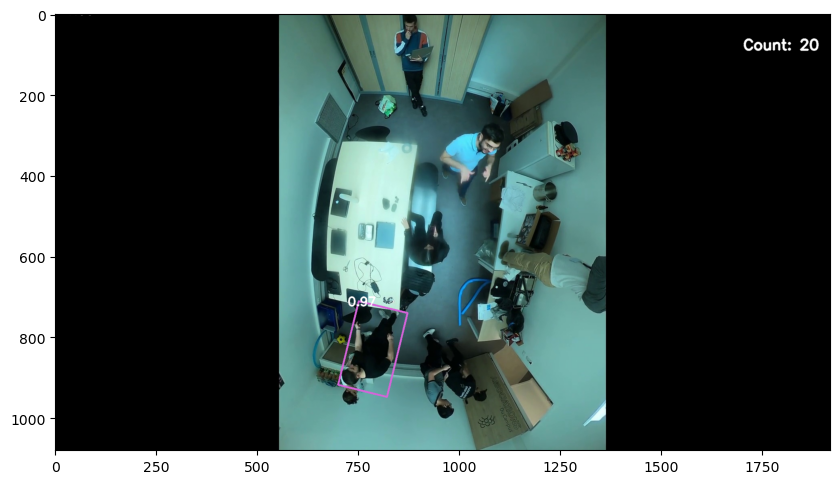

Iteration 13


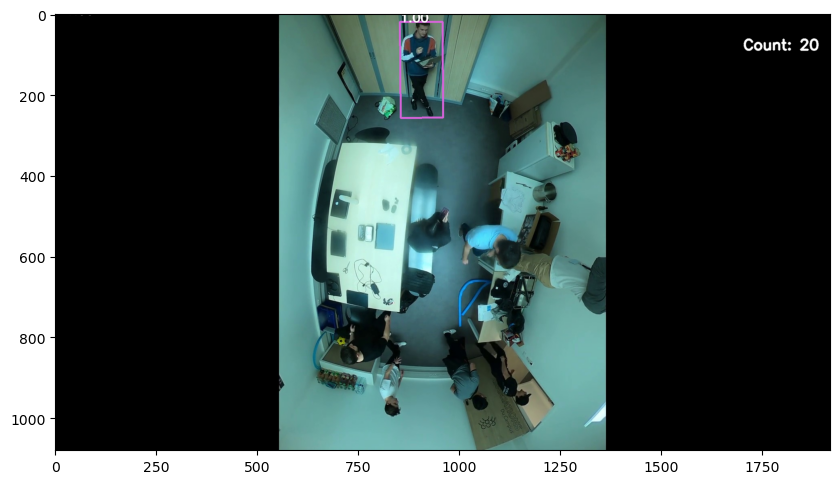

Iteration 14


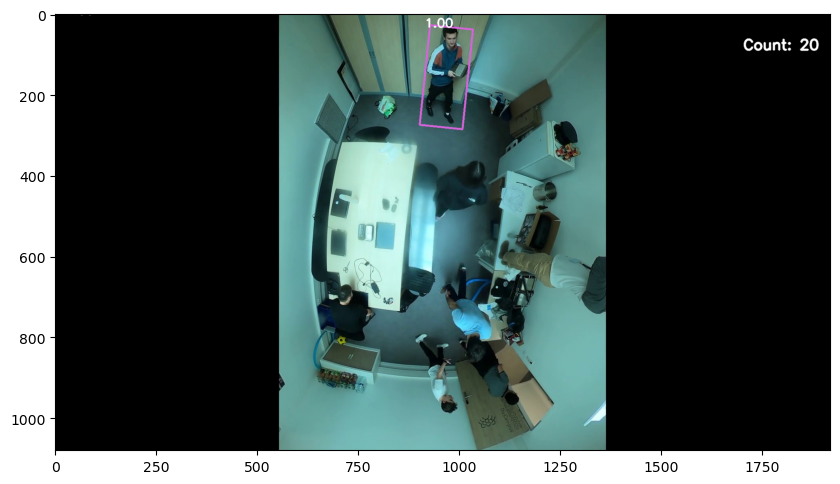

Iteration 15


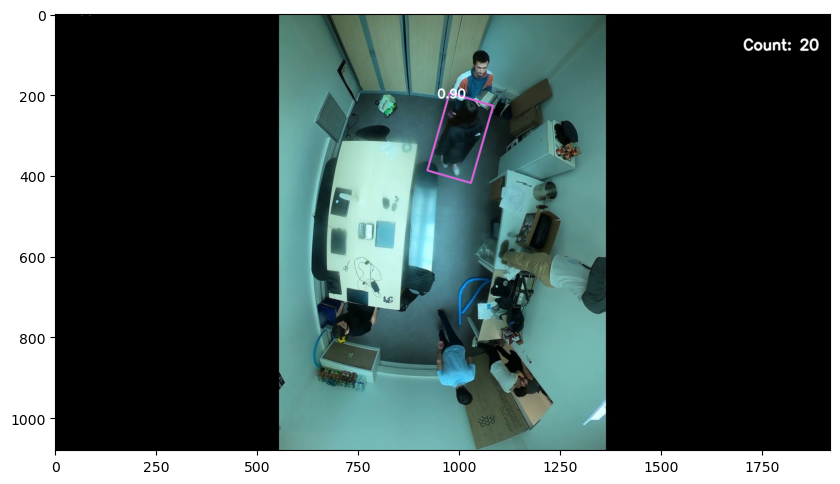

Iteration 16


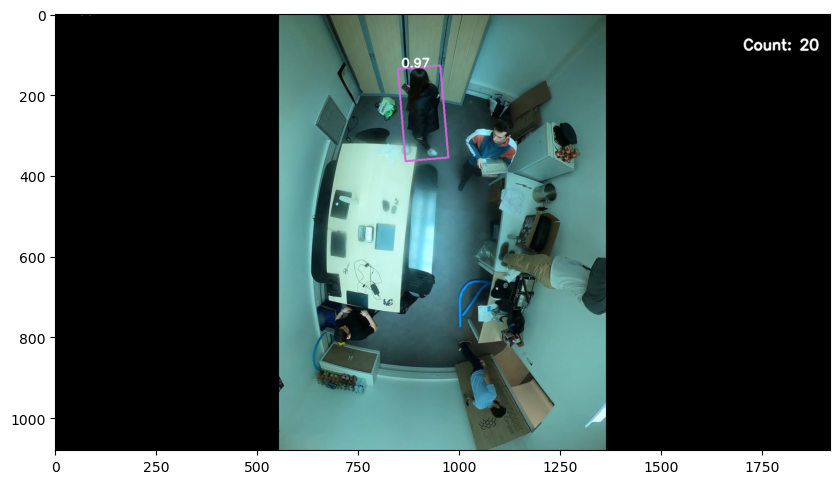

Iteration 17


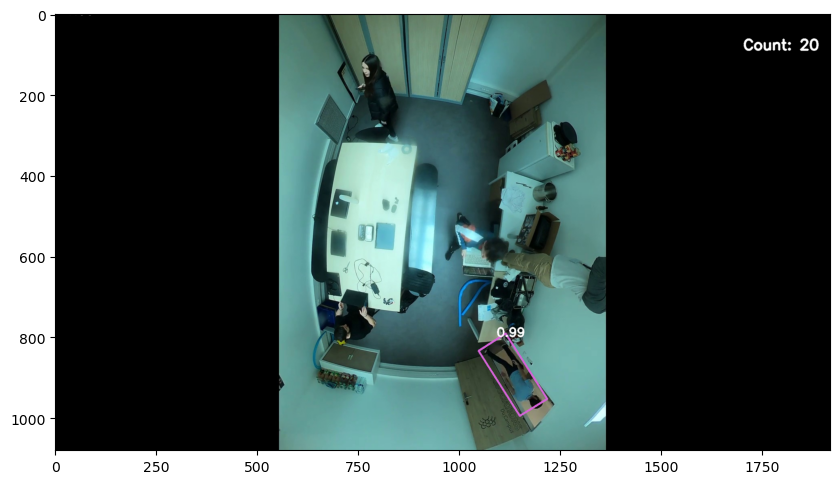

Iteration 18


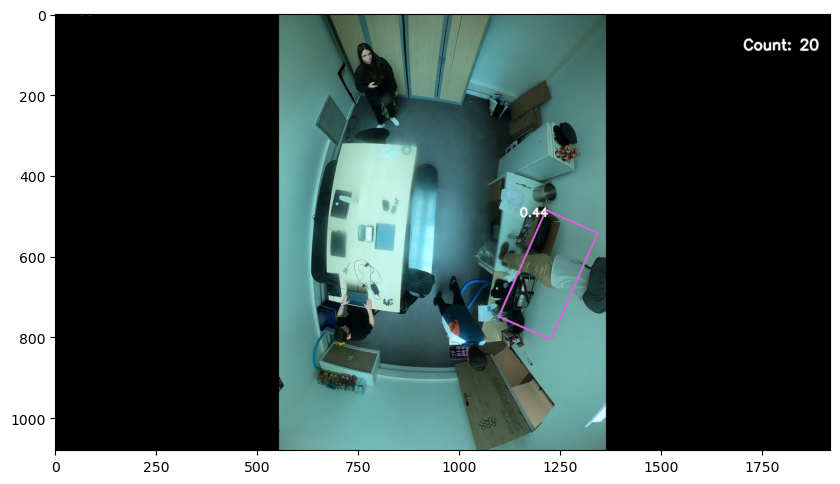

Iteration 19


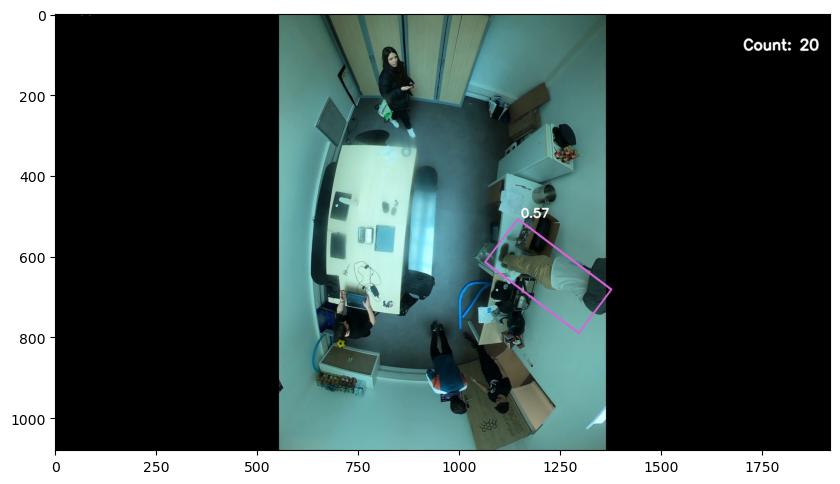

In [11]:
person_matrix = 20 * [None]
box_matrix = 20 * [(0, 0, 0, 0, 0)]

def process_images(detector, img_dir):
    for i in range(0, 20):  # Assuming you have five images
        print(f"Iteration {i}")
        img_path = f'{img_dir}/frame_{i}.jpg'
        img = Image.open(img_path)
        detection = detector._predict_pil(pil_img=img, return_img=True, input_size=1024, conf_thres=0.3, test_aug=None)
        
        # Convert PIL image to numpy array for processing
        np_img = np.array(img)
        
        # Extract person images
        detection_persons = extract_person_image(np_img, detection)
        
        # TODO : Problème une fois qu'il perd une détection il ne la récupère pas voir 
        # les différents concepts de deep_sort pour implémenter d'autres solutions
        sort_people(detection_persons, detection)
        draw_dt_on_np(np_img, box_matrix, input_size=1024, conf_thres=0.3, test_aug=None)
        plt.figure(figsize=(10,10))
        plt.imshow(np_img)
        plt.show()


# Assuming detector is an instance of your Detector class
process_images(detector, './images/video_frames')